In [1]:
# Current directory
import os
os.chdir('E:\Experiment\work')

### 导入数据

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split

X_new=pd.read_csv(r'train_feature/feature\DDE+DPC+CSKAAP+AAC+ESMC300+PAAC+APAAC+CTriad.csv',header=None)
y_new= pd.read_csv(r'data/label_train.csv',header=None)

# X_new1=pd.read_csv(r"teat_feature\DDE+DPC+CSKAAP+AAC+ESMC300+PAAC.csv",header=None)
# y_new1= pd.read_csv(r'data/label_test.csv',header=None)


print(X_new.shape)
print(y_new.shape)
# print(X_new1.shape)
# print(y_new1.shape)

X_new = np.array(X_new)
y_new = np.array(y_new).ravel()



(2872, 3772)
(2872, 1)


### 寻找最佳参数

In [100]:

from sklearn.model_selection import train_test_split
#   20%的数据作为测试集，80%作为训练集
X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X_new, y_new, test_size=0.2, random_state=1111)

print(X_train_whole.shape)
print(X_ind_test.shape)


(2297, 960)
(575, 960)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': (1,1000,100),
    'max_depth': (1,500,50),
    # 'max_features': ['log2', 'sqrt'],
    'min_samples_split':[10,100,1000,500]
}

# Initialize the RandomForestClassifier
clf = RandomForestClassifier()

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc')

# Perform grid search
grid_search.fit(X_new, y_new)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_mean_score = grid_search.best_score_

# Print the results
print("Best parameters:", best_params)
print("Best mean balanced accuracy:", best_mean_score)


### 测试

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve
import numpy as np
import pandas as pd
import math
import statistics

# 初始化各项指标
AAC_collection = []
Sn_collecton = []
Sp_collecton = []
MCC_collecton = []
AUC_collecton = []
PRROC_collecton = []  # 添加 PRROC 存储列表

# 存储所有预测信息
y_true_all = []
y_pred_all = []
y_pred_proba_all = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

# 模型定义
clf = RandomForestClassifier(max_depth=15, n_estimators=200, min_samples_split=2, n_jobs=-1)
skf = StratifiedKFold(n_splits=5)

# K折交叉验证
for train, test in skf.split(X_new, y_new):
    X_train, X_valid = X_new[train], X_new[test]
    y_train, y_valid = y_new[train], y_new[test]

    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_valid)
    y_valid_pred = categorical_probas_to_classes(y_pred_proba)

    # 保存所有结果
    y_true_all.extend(y_valid)
    y_pred_all.extend(y_valid_pred)
    y_pred_proba_all.extend(y_pred_proba[:, 1])  # 取正类的概率

    # 评估指标
    TN, FP, FN, TP = confusion_matrix(y_valid, y_valid_pred).ravel()
    Sn_collecton.append(TP / (TP + FN))
    AAC_collection.append((TP + TN) / (TP + TN + FP + FN))
    Sp_collecton.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC_collecton.append(MCC)
    auc = roc_auc_score(y_valid, y_pred_proba[:, 1])
    AUC_collecton.append(auc)
    auprc = average_precision_score(y_valid, y_pred_proba[:, 1])  # 新增 PRROC 计算
    PRROC_collecton.append(auprc)

# 保存为CSV文件
results_df = pd.DataFrame({
    'Predicted_Proba': np.round(y_pred_proba_all, 8),
    'True_Label': y_true_all,
    'Predicted_Label': y_pred_all
})
# results_df.to_csv(r'result/10折/RF单个特征/CTriad_RF.csv', index=False)

# 输出评估结果
print(round(statistics.mean(AAC_collection), 3), '±', round(statistics.stdev(AAC_collection), 3))
print(round(statistics.mean(Sn_collecton), 3), '±', round(statistics.stdev(Sn_collecton), 3))
print(round(statistics.mean(Sp_collecton), 3), '±', round(statistics.stdev(Sp_collecton), 3))
print(round(statistics.mean(MCC_collecton), 3), '±', round(statistics.stdev(MCC_collecton), 3))
print(round(statistics.mean(AUC_collecton), 3), '±', round(statistics.stdev(AUC_collecton), 3))
print(round(statistics.mean(PRROC_collecton), 3), '±', round(statistics.stdev(PRROC_collecton), 3))  # 输出 PRROC

# ==== 新增：保存 PR 曲线数据到 CSV ====
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true_all, y_pred_proba_all)

# 补全 threshold 最后一项，以便行数匹配
thresholds = np.append(thresholds, 1.0)

# 构建并保存 DataFrame
pr_curve_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precision_vals,
    'Recall': recall_vals
})
pr_curve_df.to_csv('result/10折/RF-PRROC/PR_curve_ESMC.csv', index=False)



In [ ]:
import math
import joblib
import numpy as np
import statistics
import matplotlib.pyplot as plt  # 导入matplotlib用于绘图
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# result collection list
AAC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []

# 存储每折的训练和验证损失
train_losses = []
valid_losses = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

from sklearn.ensemble import RandomForestClassifier

# 参数调整
model = RandomForestClassifier(
    n_estimators= 5,  # 增加决策树数量
    max_depth=1,      # 增加每棵树的最大深度
    min_samples_split=2,  # 每个节点的最小样本数
    # min_samples_leaf=1,   # 每个叶子节点的最小样本数
    n_jobs=-1
)
# 使用 StratifiedKFold 进行交叉验证
skf = StratifiedKFold(n_splits=5)

for fold, (train, test) in enumerate(skf.split(X_train_whole, y_train_whole), 1):
    X_train, X_valid, y_train, y_valid = X_train_whole[train], X_train_whole[test], y_train_whole[train], y_train_whole[test]
    
    # 创建并训练模型
    
    clf.fit(X_train, y_train)
    
     # 保存模型
    model_filename = f'mode\RF_ESM300/rf_ESM300_model_fold_{fold}.joblib'
    joblib.dump(clf, model_filename)  # 保存当前折的模型

    # 训练集预测概率和损失
    y_train_pred_proba = clf.predict_proba(X_train)
    train_loss = log_loss(y_train, y_train_pred_proba)
    train_losses.append(train_loss)
    
    # 验证集预测概率和损失
    y_valid_pred_proba = clf.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, y_valid_pred_proba)
    valid_losses.append(valid_loss)
    
    # 预测并计算评估指标
    y_pred = categorical_probas_to_classes(y_valid_pred_proba)
    y_true = y_valid
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel()
    Sn_collection.append(TP / (TP + FN))
    AAC_collection.append((TP + TN) / (TP + TN + FP + FN))
    Sp_collection.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.pow(((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)), 0.5)
    MCC_collection.append(MCC)
    auc = roc_auc_score(y_true, y_valid_pred_proba[:, 1])
    AUC_collection.append(auc)


print(AAC_collection)
print(Sn_collection)
print(Sp_collection)
print(MCC_collection)
print(AUC_collection)


# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 输出评估结果
print(round(statistics.mean(AAC_collection), 3), '±', round(statistics.stdev(AAC_collection), 3))
print(round(statistics.mean(Sn_collection), 3), '±', round(statistics.stdev(Sn_collection), 3))
print(round(statistics.mean(Sp_collection), 3), '±', round(statistics.stdev(Sp_collection), 3))
print(round(statistics.mean(MCC_collection), 3), '±', round(statistics.stdev(MCC_collection), 3))
print(round(statistics.mean(AUC_collection), 3), '±', round(statistics.stdev(AUC_collection), 3))


In [17]:
import math
import joblib
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline

# —— 安全除法函数 ——
def safe_divide(a, b):
    return a / b if b != 0 else 0

# —— RF 超参 ——
rf_params = {
    'n_estimators': 300,
    'max_depth': 15,
    'min_samples_split': 7,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'oob_score': True,
    'n_jobs': -1,
    'class_weight': {0: 1627, 1: 1245},
    'random_state': 42
}

# —— 5‑折交叉验证，逐折打印指标 ——
cv = StratifiedKFold(n_splits=5)

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import math

print("\n========== 5‑折逐折评估 ==========")
for fold, (train_idx, test_idx) in enumerate(cv.split(X_new, y_new), start=1):
    # 1) 每折单独建管道并训练
    model = make_pipeline(
        RandomForestClassifier(**rf_params)
    )
    model.fit(X_new[train_idx], y_new[train_idx])
    
    # 2) 预测
    y_pred  = model.predict(X_new[test_idx])
    y_proba = model.predict_proba(X_new[test_idx])[:, 1]
    
    # 3) 指标
    TN, FP, FN, TP = confusion_matrix(y_new[test_idx], y_pred).ravel()
    ACC = safe_divide(TP + TN, TP + TN + FP + FN)
    Sn  = safe_divide(TP, TP + FN)
    Sp  = safe_divide(TN, TN + FP)
    MCC_num = TP * TN - FP * FN
    MCC_den = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC = safe_divide(MCC_num, MCC_den)
    AUC = roc_auc_score(y_new[test_idx], y_proba)

    # —— 新增 F1 —— 
    F1 = f1_score(y_new[test_idx], y_pred)
    
    # 4) 打印
    print(f"Fold {fold}: "
          f"ACC={ACC:.3f}  "
          f"Sn={Sn:.3f}  "
          f"Sp={Sp:.3f}  "
          f"MCC={MCC:.3f}  "
          f"AUC={AUC:.3f}  "
          f"F1={F1:.3f}")

# —— 在完整训练集上拟合一次，用于 OOB 分数 —— 
final_model = make_pipeline(
    RandomForestClassifier(**rf_params)
)
final_model.fit(X_new, y_new)
oob_score = final_model.named_steps['randomforestclassifier'].oob_score_
print(f"\nOOB Score on full data: {oob_score:.3f}")




========== 5‑折逐折评估 ==========
Fold 1: ACC=0.708  Sn=0.562  Sp=0.819  MCC=0.397  AUC=0.730  F1=0.625
Fold 2: ACC=0.661  Sn=0.486  Sp=0.794  MCC=0.296  AUC=0.717  F1=0.554
Fold 3: ACC=0.685  Sn=0.506  Sp=0.822  MCC=0.348  AUC=0.735  F1=0.582
Fold 4: ACC=0.699  Sn=0.578  Sp=0.791  MCC=0.379  AUC=0.746  F1=0.625
Fold 5: ACC=0.723  Sn=0.530  Sp=0.871  MCC=0.432  AUC=0.776  F1=0.624

OOB Score on full data: 0.687


In [27]:
# 独立测试
import math
import numpy as np
import statistics
from sklearn.metrics import confusion_matrix,roc_auc_score

AAC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []


def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

for i in range(5):
    # dataset splitting
    # X_train_whole, X_ind_test, y_train_whole, y_ind_test = train_test_split(X_new, y_new, test_size=0.2, random_state=1111)
    
    # Create and train Decision Tree classifier
    # clf = RandomForestClassifier(max_depth=600, max_features=1, n_estimators=1000, n_jobs=-1)  # need to tune the hyperparameters
    # clf.fit(X_train_whole, y_train_whole)
    # clf = joblib.load('mode\RF_ESM300/rf_ESM300_model_fold_5.joblib')
    # Predict on independent test set
    clf.fit(X_new, y_new)
    y_pred_score = clf.predict_proba(X_new1)
    y_pred = categorical_probas_to_classes(y_pred_score)
    y_true = y_new1
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel()
    Sn_collection.append(TP / (TP + FN))
    AAC_collection.append((TP + TN) / (TP + TN + FP + FN))
    Sp_collection.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.pow(((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)), 0.5)
    MCC_collection.append(MCC)
    auc = roc_auc_score(y_true, y_pred_score[:, 1])
    AUC_collection.append(auc)
  
# Print results
print(round(statistics.mean(AAC_collection), 3), '±', round(statistics.stdev(AAC_collection), 3))
print(round(statistics.mean(Sn_collection), 3), '±', round(statistics.stdev(Sn_collection), 3))
print(round(statistics.mean(Sp_collection), 3), '±', round(statistics.stdev(Sp_collection), 3))
print(round(statistics.mean(MCC_collection), 3), '±', round(statistics.stdev(MCC_collection), 3))
print(round(statistics.mean(AUC_collection), 3), '±', round(statistics.stdev(AUC_collection), 3))


0.607 ± 0.01
0.577 ± 0.008
0.678 ± 0.014
0.234 ± 0.021
0.682 ± 0.005


In [37]:
import math
import numpy as np
import statistics
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score

# 结果收集容器
AAC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []

# 所有折的预测记录
all_preds = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

for i in range(5):
    # 假设 clf、X_new, y_new, X_new1, y_new1 是预定义好的
    clf.fit(X_new, y_new)
    y_pred_score = clf.predict_proba(X_new1)
    y_pred = categorical_probas_to_classes(y_pred_score)
    y_true = y_new1

    # 混淆矩阵计算
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel()
    Sn_collection.append(TP / (TP + FN))
    AAC_collection.append((TP + TN) / (TP + TN + FP + FN))
    Sp_collection.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    MCC_collection.append(MCC)
    auc = roc_auc_score(y_true, y_pred_score[:, 1])
    AUC_collection.append(auc)

    # 保存当前折的预测结果
    # 保存当前折的预测结果
    df_fold = pd.DataFrame({
    'Fold': [i + 1] * len(y_true),
    'True_Label': np.ravel(y_true),
    'Predicted_Label': np.ravel(y_pred),
    'Predicted_Probability': np.ravel(y_pred_score[:, 1])
    })



    all_preds.append(df_fold)

# 合并所有折结果
pred_results_df = pd.concat(all_preds, ignore_index=True)

# 保存到 CSV
pred_results_df.to_csv('E:\Experiment\work\DDE_test_predictions.csv', index=False)

# 打印指标统计
print(round(statistics.mean(AAC_collection), 3), '±', round(statistics.stdev(AAC_collection), 3))
print(round(statistics.mean(Sn_collection), 3), '±', round(statistics.stdev(Sn_collection), 3))
print(round(statistics.mean(Sp_collection), 3), '±', round(statistics.stdev(Sp_collection), 3))
print(round(statistics.mean(MCC_collection), 3), '±', round(statistics.stdev(MCC_collection), 3))
print(round(statistics.mean(AUC_collection), 3), '±', round(statistics.stdev(AUC_collection), 3))


0.657 ± 0.007
0.619 ± 0.004
0.733 ± 0.015
0.333 ± 0.017
0.688 ± 0.003


In [655]:
import math
import numpy as np
import statistics
import joblib
from sklearn.metrics import confusion_matrix, roc_auc_score

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

def safe_divide(a, b):
    """处理除零错误的安全除法"""
    return a / b if b != 0 else 0

# 初始化结果收集列表
metrics = {
    'AAC': [], 'Sn': [], 'Sp': [], 
    'MCC': [], 'AUC': []
}

# 加载模型并测试
for i in range(5):
    try:
        # 加载模型（注意路径修正）
        clf = joblib.load(f'model/RF_ESM300/rf_ESM300_model_fold_{i+1}.joblib')
        
        # 预测
        y_pred_score = clf.predict_proba(X_new1)
        y_pred = categorical_probas_to_classes(y_pred_score)
        y_true = y_new1
        
        # 计算混淆矩阵
        cm = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = cm.ravel()
        
        # 计算指标（使用安全除法）
        metrics['AAC'].append(safe_divide(TP + TN, TP + TN + FP + FN))
        metrics['Sn'].append(safe_divide(TP, TP + FN))
        metrics['Sp'].append(safe_divide(TN, TN + FP))
        
        # 计算MCC
        numerator = (TP * TN - FP * FN)
        denominator = math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        metrics['MCC'].append(safe_divide(numerator, denominator))
        
        # 计算AUC
        metrics['AUC'].append(roc_auc_score(y_true, y_pred_score[:, 1]))
    
    except Exception as e:
        print(f"Fold {i+1} 测试出错: {str(e)}")
        continue

# 打印格式化结果
print("\n========== 独立测试结果 ==========")
print(f"模型数量: {len(metrics['AAC'])}")
print("指标\t均值 ± 标准差")
print("-------------------------------")
for metric in metrics:
    if metrics[metric]:  # 只输出有结果的指标
        mean_val = statistics.mean(metrics[metric])
        std_val = statistics.stdev(metrics[metric]) if len(metrics[metric]) > 1 else 0
        print(f"{metric}\t{mean_val:.3f} ± {std_val:.3f}")

# 各fold详细结果
print("\n各Fold详细结果:")
for i in range(len(metrics['AAC'])):
    print(f"Fold {i+1}: ", end="")
    for metric in metrics:
        print(f"{metric}={metrics[metric][i]:.3f}", end="  ")
    print()

Fold 1 测试出错: [Errno 2] No such file or directory: 'model/RF_ESM300/rf_ESM300_model_fold_1.joblib'
Fold 2 测试出错: [Errno 2] No such file or directory: 'model/RF_ESM300/rf_ESM300_model_fold_2.joblib'
Fold 3 测试出错: [Errno 2] No such file or directory: 'model/RF_ESM300/rf_ESM300_model_fold_3.joblib'
Fold 4 测试出错: [Errno 2] No such file or directory: 'model/RF_ESM300/rf_ESM300_model_fold_4.joblib'
Fold 5 测试出错: [Errno 2] No such file or directory: 'model/RF_ESM300/rf_ESM300_model_fold_5.joblib'

========== 独立测试结果 ==========
模型数量: 0
指标	均值 ± 标准差
-------------------------------

各Fold详细结果:


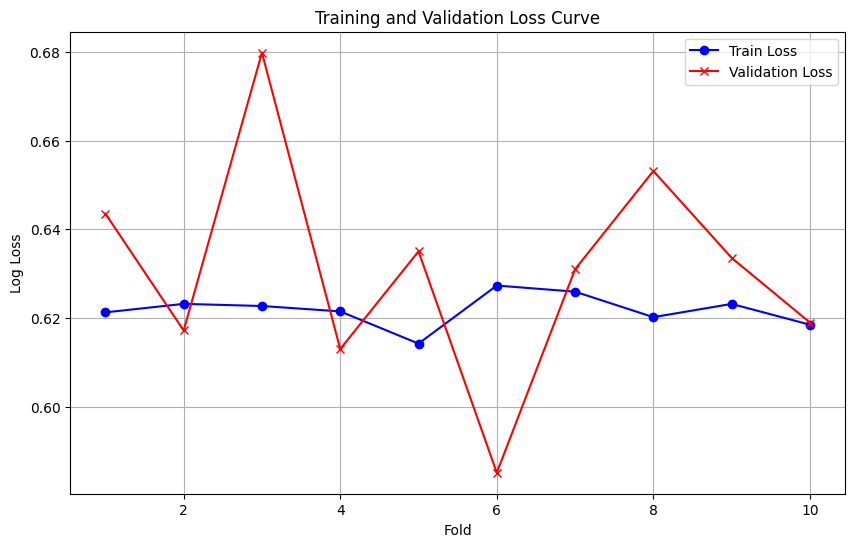

0.67 ± 0.036
0.675 ± 0.028
0.662 ± 0.061
0.319 ± 0.076
0.668 ± 0.038


In [478]:
import math
import numpy as np
import statistics
import matplotlib.pyplot as plt  # 导入matplotlib用于绘图
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# result collection list
AAC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []

# 存储每折的训练和验证损失
train_losses = []
valid_losses = []

def categorical_probas_to_classes(p):
    return np.argmax(p, axis=1)

clf = RandomForestClassifier(n_estimators=1, 
                             max_depth=2, 
                             min_samples_split=2 ,
                             min_samples_leaf=2,  
                             n_jobs=-1)

# 使用 StratifiedKFold 进行交叉验证
skf = StratifiedKFold(n_splits=10)

for fold, (train, test) in enumerate(skf.split(X_train_whole, y_train_whole), 1):
    X_train, X_valid, y_train, y_valid = X_train_whole[train], X_train_whole[test], y_train_whole[train], y_train_whole[test]
    
    # 创建并训练模型
    
    clf.fit(X_train, y_train)
    
    # 训练集预测概率和损失
    y_train_pred_proba = clf.predict_proba(X_train)
    train_loss = log_loss(y_train, y_train_pred_proba)
    train_losses.append(train_loss)
    
    # 验证集预测概率和损失
    y_valid_pred_proba = clf.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, y_valid_pred_proba)
    valid_losses.append(valid_loss)
    
    # 预测并计算评估指标
    y_pred = categorical_probas_to_classes(y_valid_pred_proba)
    y_true = y_valid
    TP, FP, FN, TN = confusion_matrix(y_true, y_pred).ravel()
    Sn_collection.append(TP / (TP + FN))
    AAC_collection.append((TP + TN) / (TP + TN + FP + FN))
    Sp_collection.append(TN / (TN + FP))
    MCC = (TP * TN - FP * FN) / math.pow(((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)), 0.5)
    MCC_collection.append(MCC)
    auc = roc_auc_score(y_true, y_valid_pred_proba[:, 1])
    AUC_collection.append(auc)

# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# 输出评估结果
print(round(statistics.mean(AAC_collection), 3), '±', round(statistics.stdev(AAC_collection), 3))
print(round(statistics.mean(Sn_collection), 3), '±', round(statistics.stdev(Sn_collection), 3))
print(round(statistics.mean(Sp_collection), 3), '±', round(statistics.stdev(Sp_collection), 3))
print(round(statistics.mean(MCC_collection), 3), '±', round(statistics.stdev(MCC_collection), 3))
print(round(statistics.mean(AUC_collection), 3), '±', round(statistics.stdev(AUC_collection), 3))


### 结尾